# **3 - CNN**

# Introduction

Convolutional Neural Networks or CNNs are a type of neural network widely used for image-related tasks, such as image classification, object detection or semantic segmentation. However, they can also be used for text-related tasks. In this notebook, we will use a CNN for classifying news headlines into sarcastic and not sarcastic.

The main difference between using CNNs for dealing with images and text is the input dimensionality. When dealing with images, these can have 2 dimensions if dealing with grayscale images or 3 dimensions if dealing with RGB images (due to the three channels the image have, one per color). Therefore, in those cases we would apply 2 by 2 filters or *kernels* in order to extract features from the image. However, when dealing with text, the input is a 1-dimensional vector. As we have already seen in previous notebooks, we tokenize our text by assigning an index to each word. Once we have converted our headlines into sequences of numbers, we apply the *Embedding* technique to convert each number (i.e, each word) into a vector of a fixed size. We could interpret each component of the vector as the equivalent of a channel in an image. Therefore, in text-related tasks, if using a CNN, we would apply a 1D convolution (and therefore, a 1D kernel), with a specific stride, to extract features from the text. In addition, *Max-pooling* and *Padding* can be applied as well. In the following image this, process is illustrated:

<p align="left">
<img src="https://machinelearningmastery.com/wp-content/uploads/2017/10/Depiction-of-the-multiple-channel-convolutional-neural-network-for-text.png"/>
</p>

*Figure 1: [How to Develop a Multichannel CNN Model for Text Classification](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/), Machine Learning Mastery*

Therefore, our headlines the input of the CNN will be a 2-dimensional matrix, where each row corresponds to a word of the headline (i.e, a vector of fixed size) and each column corresponds to one coordinate of the embedding space.

Let's load the required libraries in order to run the code:

In [1]:
import os

import pandas as pd
import numpy as np
# import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from src.data_preprocessing import train_test_split, tokenization
from src.utils import plot_metric_curves

## Load dataset

Let's load the dataset generated in `0-EDA.ipynb`:

In [2]:
dataset = os.path.join("data", "Sarcasm_Headlines_Dataset_v2.csv")

df = pd.read_csv(dataset, sep=";")
df.head()

,headline,label
0,scientist unveil doomsday clock hair loss,1
1,dem rep totally nail congress falling short ge...,0
2,eat different recipe,0
3,weather prevents liar getting work,1
4,mother come pretty close using word streaming ...,1


## Split data into train and test sets

We need to generate both training and test sets. We will use 80% of the data for training and the remaining 20% for testing. Moreover, in classification tasks it is important to maintain the same proportion of classes in both training and test sets (otherwise, the model might be affected by it during the training process, and the validation metrics may also be distorted). `scikit-learn` offers the class `StratifiedShuffleSplit` for achieving this, which will be used. We have developed the `train_test_split` function, which is stored in `src/data_preprocessing.py`:

In [3]:
X_train, y_train, X_test, y_test = train_test_split(df, "label")

Let's check that the training set contains 80% of data:

In [4]:
np.round(len(X_train) / len(df), 2)

0.8

Let's also check that the distribution of classes in both sets are almost the same:

In [5]:
y_train.value_counts(normalize=True)

0    0.518145
1    0.481855
Name: label, dtype: float64

In [6]:
y_test.value_counts(normalize=True)

0    0.518237
1    0.481763
Name: label, dtype: float64

# Tokenization, Padding and Sequencing

As mentioned in the previous notebook, we need to tokenize the text before feeding the data into our model. For doing so, we will apply the function `tokenization` from `src/data_preprocessing.py` we have developed:

In [7]:
# Define tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
# Obtain padded train and test sequences, length of longest sequence and vocabulary size
train_padded, test_padded, max_seq_len, vocab_size = tokenization(tokenizer, X_train, X_test, "headline") 

## Build the model

In [8]:
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=max_seq_len))

# Convolutional layer
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# Flatten and classifier
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))

# Output layer
model.add(Dense(1, activation="sigmoid"))

In [9]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["acc"])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 50)            383550    
                                                                 
 conv1d (Conv1D)             (None, 14, 16)            2416      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 16)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 16)             0         
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dropout_1 (Dropout)         (None, 112)               0         
                                                        

## Train the model

Let's first create a folder where to save our models.

In [11]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

In [12]:
# Model name and path
model_path = os.path.join("models", "cnn_model.h5")

We use `EarlyStopping` to limit *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training. We will using validation loss as metric function for early stopping, setting a patience of 5 (i.e.: we will stop after there is no improvement in validation loss for 5 epochs of training). Since we are dealing with a relatively small dataset, we can set a high enough number of epochs, as we can be fairly sure that training will be stopped before reaching the limit.

In [13]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [14]:
history = model.fit(
    train_padded, np.array(y_train),
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(test_padded, np.array(y_test)),
    callbacks = [es, mc]
)

Epoch 1/30
334/338 [============================>.] - ETA: 0s - loss: 0.6051 - acc: 0.6531
Epoch 1: val_loss improved from inf to 0.45150, saving model to models\cnn_model.h5
338/338 [==============================] - 3s 7ms/step - loss: 0.6042 - acc: 0.6541 - val_loss: 0.4515 - val_acc: 0.7884
Epoch 2/30
334/338 [============================>.] - ETA: 0s - loss: 0.3888 - acc: 0.8276
Epoch 2: val_loss improved from 0.45150 to 0.41866, saving model to models\cnn_model.h5
338/338 [==============================] - 2s 6ms/step - loss: 0.3886 - acc: 0.8279 - val_loss: 0.4187 - val_acc: 0.8052
Epoch 3/30
333/338 [============================>.] - ETA: 0s - loss: 0.2973 - acc: 0.8788
Epoch 3: val_loss did not improve from 0.41866
338/338 [==============================] - 2s 6ms/step - loss: 0.2972 - acc: 0.8788 - val_loss: 0.4468 - val_acc: 0.7997
Epoch 4/30
335/338 [============================>.] - ETA: 0s - loss: 0.2441 - acc: 0.9023
Epoch 4: val_loss did not improve from 0.41866
338/338

## Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

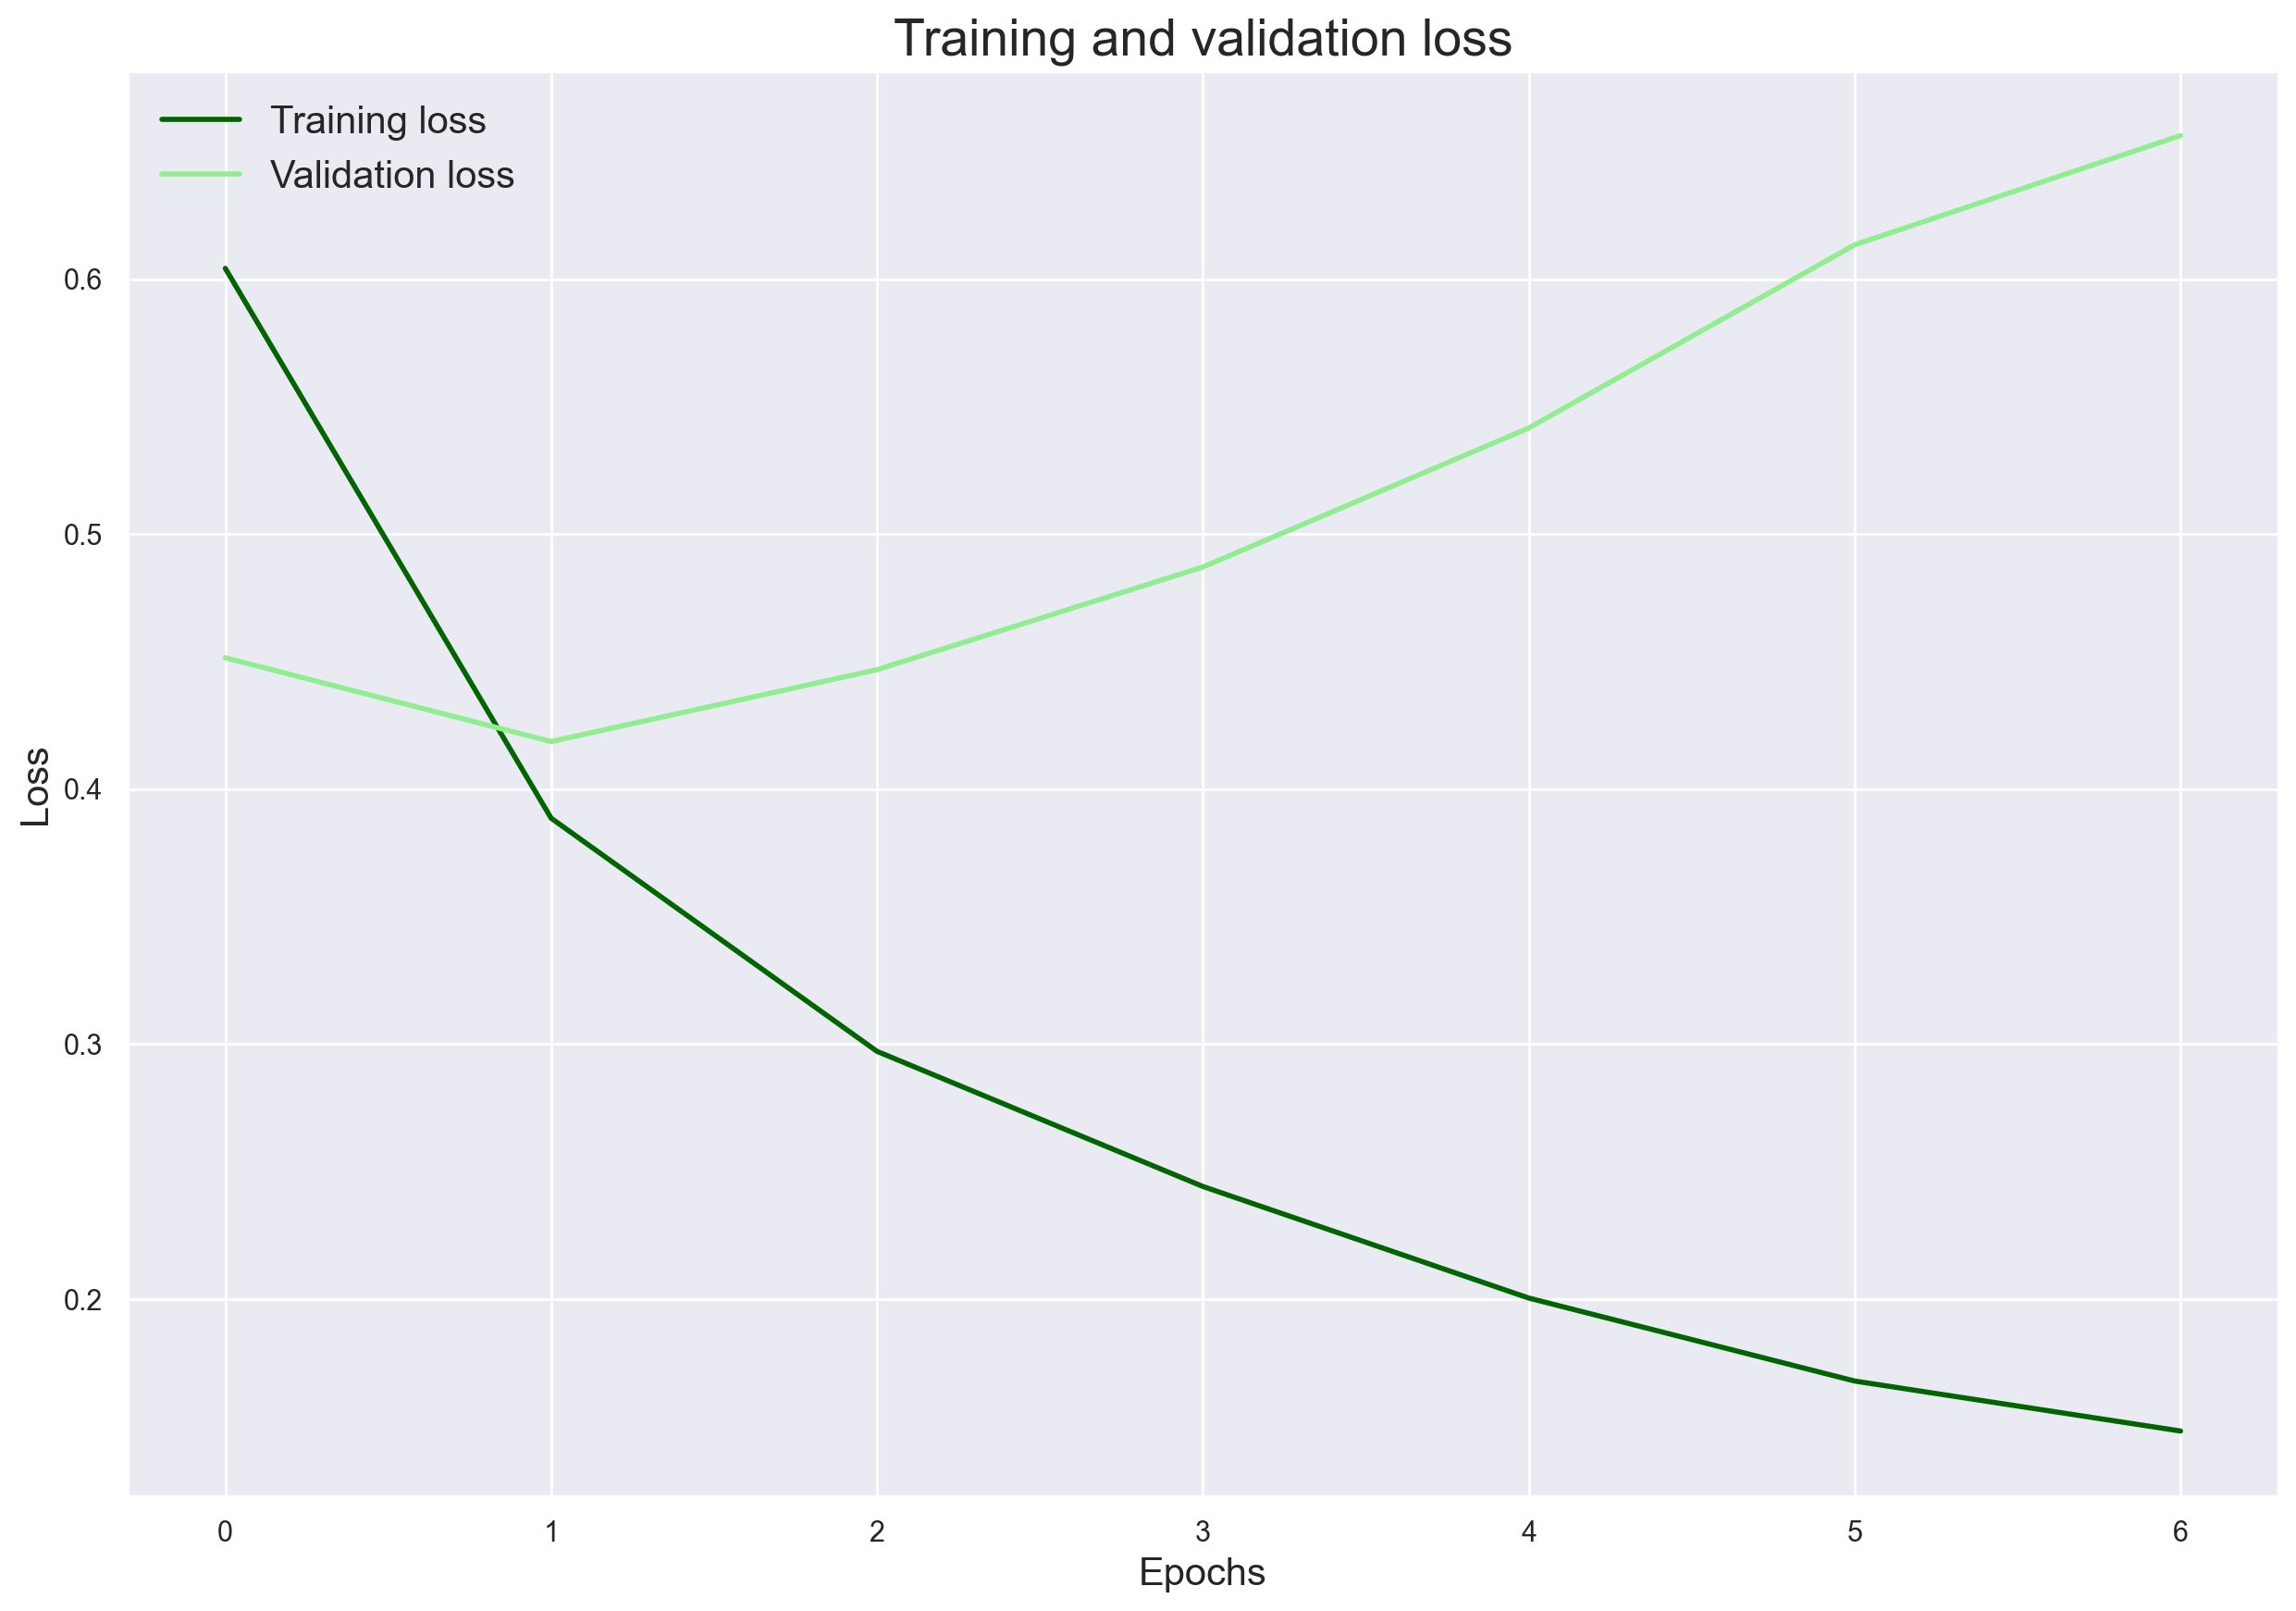

In [16]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkgreen", "lightgreen", "Loss")

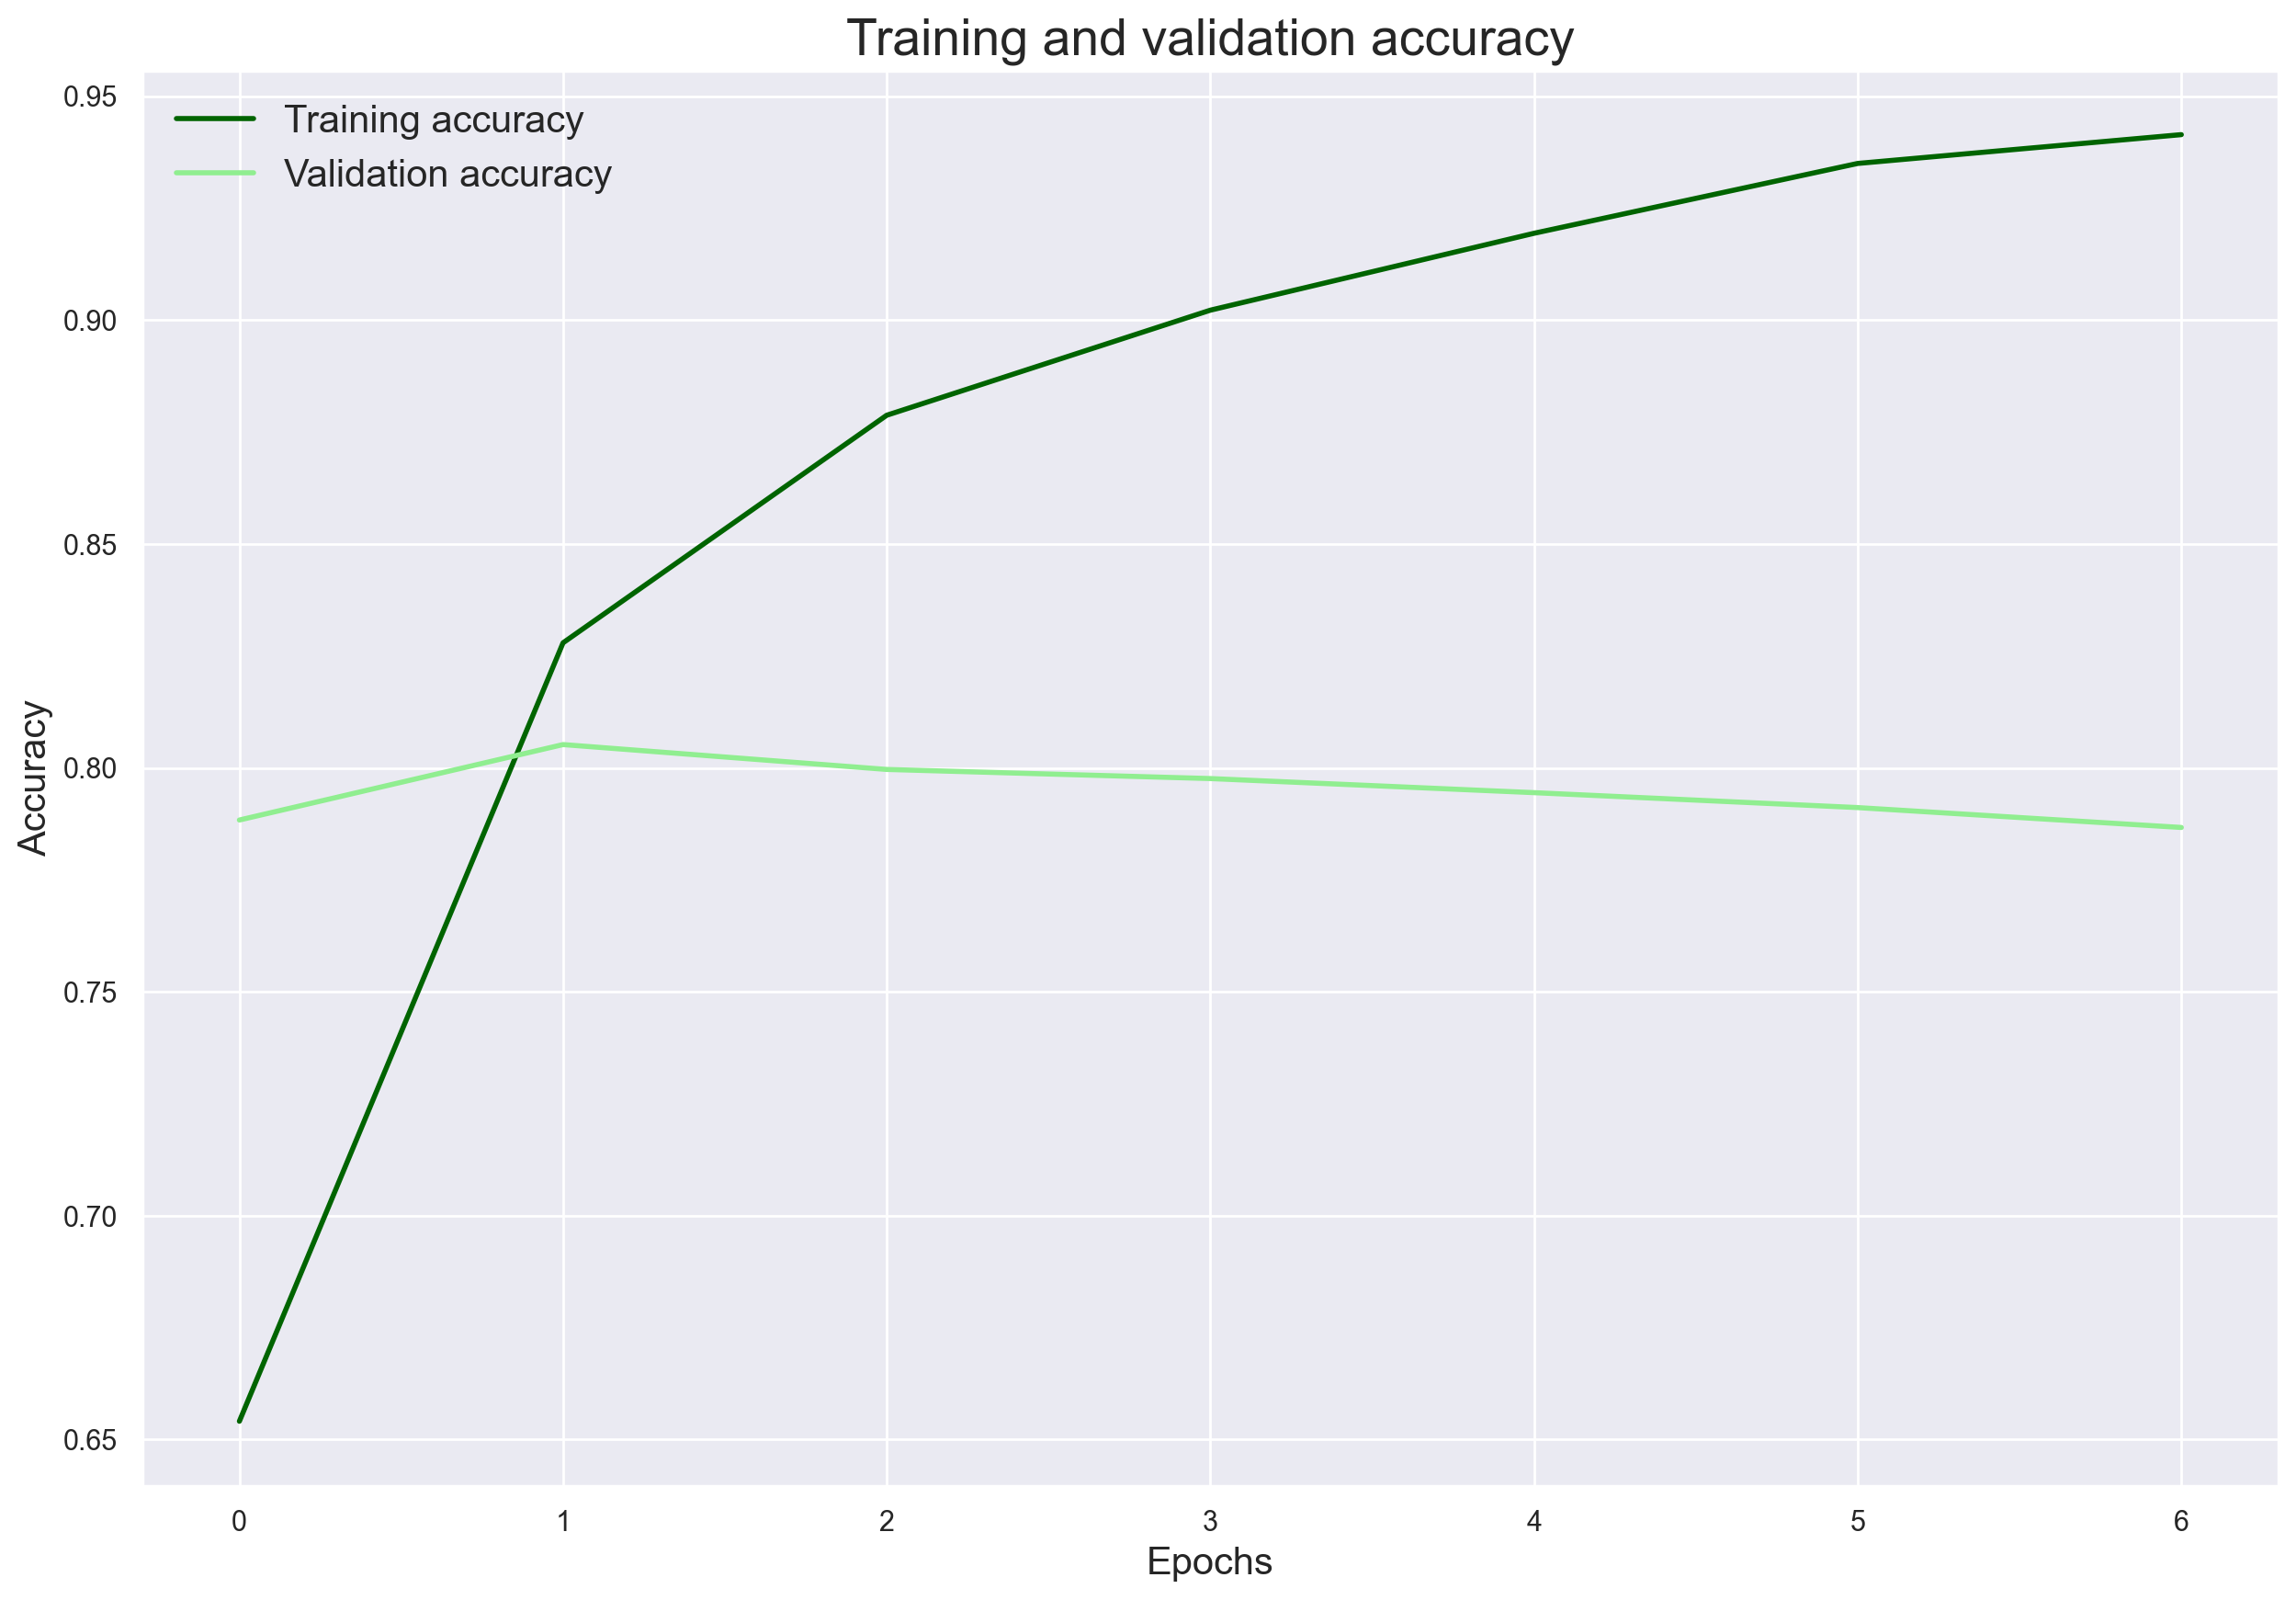

In [17]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkgreen", "lightgreen", "Accuracy")

*Comment results obtained*